In [1]:
%load_ext autoreload
%autoreload 2

# Init

In [2]:
import sys
sys.path.append("../src")
import re
from pathlib import Path

import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from scoring.scorer import FEVERScorer
from gen.util import read_data

In [3]:
scifact_actual = read_data(Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/feverised-scifact/scifact_all.jsonl"))

# Hyperparameter Evaluation

## Tune pages

In [4]:
scifact_pipeline_p10s10 = read_data(Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/scifact-pipeline-sampled/scifact.pipeline.test.n10.jsonl"))

In [5]:
pipeline_eval_d = {}

for p in tqdm(range(1, 11)):
    for s in range(1, 11):
        score_name = f"p{p}s{s}"
        pipeline_eval_d[score_name] = FEVERScorer(
            scifact_actual, scifact_pipeline_p10s10, 
            oracle_ir=False, oracle_rte=True, 
            max_evidence=s, max_pages=p,
            score_name=score_name
        )

100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


In [6]:
df_pipe = []

for k, v in pipeline_eval_d.items():
    score_d = v.score_to_dict(include_prefix=False)
    score_d["name"] = k
    ps = re.findall("p(\d{1,2})s(\d{1,2})", k)
    score_d["n_pages"] = int(ps[0][0])
    score_d["n_sents"] = int(ps[0][1])
    df_pipe.append(score_d)
df_pipe = pd.DataFrame(df_pipe)
df_pipe

,fever_score,evidence_accuracy,evidence_precision,evidence_recall,evidence_f1,document_precision,document_recall,document_f1,name,n_pages,n_sents
0,0.688007,1.0,0.529582,0.500722,0.514747,0.112554,0.099447,0.105595,p1s1,1,1
1,0.772768,1.0,0.387446,0.636364,0.481645,0.112554,0.099447,0.105595,p1s2,1,2
2,0.807033,1.0,0.314574,0.691198,0.432370,0.112554,0.099447,0.105595,p1s3,1,3
3,0.830478,1.0,0.260101,0.728716,0.383367,0.112554,0.099447,0.105595,p1s4,1,4
4,0.844004,1.0,0.223088,0.750361,0.343925,0.112554,0.099447,0.105595,p1s5,1,5
...,...,...,...,...,...,...,...,...,...,...,...
95,0.856628,1.0,0.194084,0.770563,0.310069,0.103608,0.943290,0.186708,p10s6,10,6
96,0.866546,1.0,0.172748,0.786436,0.283272,0.103608,0.943290,0.186708,p10s7,10,7
97,0.878269,1.0,0.156385,0.805195,0.261904,0.103608,0.943290,0.186708,p10s8,10,8
98,0.889089,1.0,0.143498,0.822511,0.244364,0.103608,0.943290,0.186708,p10s9,10,9


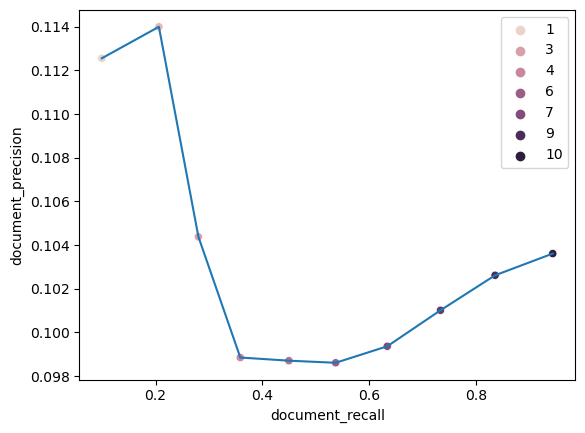

In [7]:
# 6 pages is optimal

ax = sns.scatterplot(
    data=df_pipe.groupby("n_pages", as_index=False)[["document_recall", "document_precision", "document_f1"]].mean(),
    x="document_recall", y="document_precision", hue="n_pages",
    markers=True
)
ax = sns.lineplot(
    data=df_pipe.groupby("n_pages", as_index=False)[["document_recall", "document_precision", "document_f1"]].mean(),
    x="document_recall", y="document_precision"
)

## Tune sentences

In [72]:
scifact_pipeline_p6s10 = read_data(Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/scifact-pipeline-sampled/scifact.pipeline.test.n6.jsonl"))

In [86]:
pipeline_eval_d = {}

for s in range(1, 11):
    score_name = f"p6s{s}"
    pipeline_eval_d[score_name] = FEVERScorer(
        scifact_actual, scifact_pipeline_p10s10, 
        oracle_ir=False, oracle_rte=True, 
        max_evidence=s,
        score_name=score_name
    )

In [87]:
df_pipe = []

for k, v in pipeline_eval_d.items():
    score_d = v.score_to_dict(include_prefix=False)
    score_d["name"] = k
    ps = re.findall("p(\d{1,2})s(\d{1,2})", k)
    score_d["n_pages"] = int(ps[0][0])
    score_d["n_sents"] = int(ps[0][1])
    df_pipe.append(score_d)
df_pipe = pd.DataFrame(df_pipe)
df_pipe

,fever_score,evidence_accuracy,evidence_precision,evidence_recall,evidence_f1,document_precision,document_recall,document_f1,name,n_pages,n_sents
0,0.706041,1.0,0.529582,0.529582,0.529582,0.103608,0.94329,0.186708,p6s1,6,1
1,0.792606,1.0,0.387446,0.668110,0.490465,0.103608,0.94329,0.186708,p6s2,6,2
2,0.826871,1.0,0.314574,0.722944,0.438391,0.103608,0.94329,0.186708,p6s3,6,3
3,0.850316,1.0,0.260101,0.760462,0.387623,0.103608,0.94329,0.186708,p6s4,6,4
4,0.863841,1.0,0.223088,0.782107,0.347154,0.103608,0.94329,0.186708,p6s5,6,5
5,0.875564,1.0,0.194084,0.800866,0.312448,0.103608,0.94329,0.186708,p6s6,6,6
6,0.883679,1.0,0.172748,0.813853,0.285002,0.103608,0.94329,0.186708,p6s7,6,7
7,0.895401,1.0,0.156385,0.832612,0.263314,0.103608,0.94329,0.186708,p6s8,6,8
8,0.904418,1.0,0.143498,0.847042,0.245420,0.103608,0.94329,0.186708,p6s9,6,9
9,0.908927,1.0,0.132756,0.854257,0.229800,0.103608,0.94329,0.186708,p6s10,6,10


<AxesSubplot: xlabel='n_sents'>

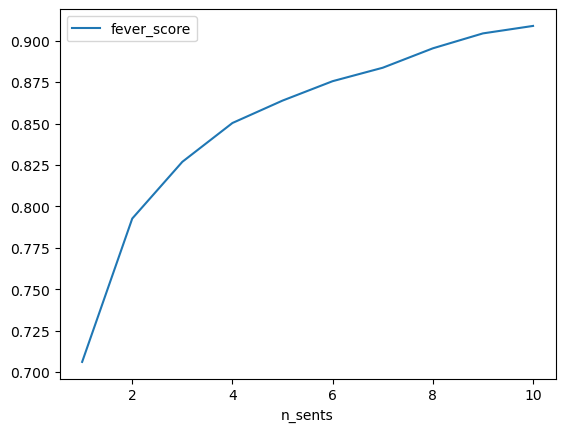

In [88]:
df_pipe.plot(x="n_sents", y="fever_score")

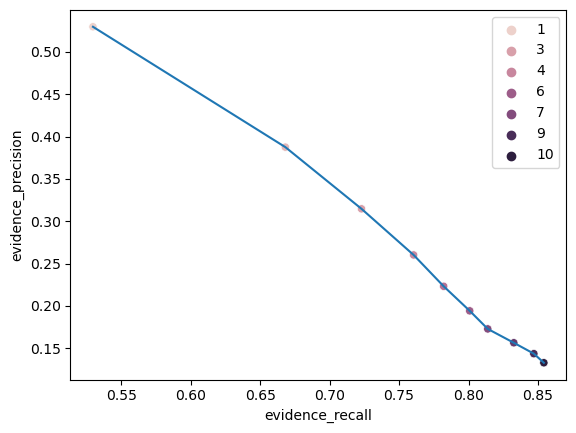

In [79]:
# 5 sentences by fever score growth seem ok
df_plt = df_pipe.groupby("n_sents", as_index=False)[["evidence_recall", "evidence_precision", "evidence_f1"]].mean()
ax = sns.scatterplot(
    data=df_plt,
    x="evidence_recall", y="evidence_precision", hue="n_sents",
    markers=True
)
ax = sns.lineplot(
    data=df_plt,
    x="evidence_recall", y="evidence_precision"
)